In [3]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.6.1.tar.gz (1.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------- --------- 30.7/41.5 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 504.9 kB/s eta 0:00:00
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     -------------------------------- ----- 51.2/60.8 kB 650.2 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 537.5 kB/s eta 0:00:00
     ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
     ----- ------------------

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH= os.path.join('data','images')
number_images=30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [13]:
!labelme

^C


2025-02-28 11:57:08.237 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\dghos\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [37]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')  #can do shuffle=False if the images to be plotted sequentially

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [28]:
images.as_numpy_iterator().next()  #Gives iterator to the image

b'data\\images\\54be695f-f59c-11ef-9e3b-80b655fcc154.jpg'

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [30]:
images = images.map(load_image)

In [35]:
images.as_numpy_iterator().next()

array([[[178, 185, 191],
        [176, 183, 189],
        [174, 183, 188],
        ...,
        [170, 175, 178],
        [169, 174, 177],
        [169, 174, 177]],

       [[177, 184, 190],
        [175, 182, 188],
        [173, 182, 187],
        ...,
        [170, 175, 178],
        [169, 174, 177],
        [169, 174, 177]],

       [[177, 184, 190],
        [175, 182, 188],
        [173, 182, 187],
        ...,
        [169, 174, 177],
        [169, 174, 177],
        [169, 174, 177]],

       ...,

       [[ 88,  78,  87],
        [ 89,  79,  88],
        [ 89,  79,  88],
        ...,
        [127, 130, 149],
        [126, 129, 148],
        [125, 128, 147]],

       [[ 88,  78,  86],
        [ 88,  78,  86],
        [ 89,  79,  87],
        ...,
        [126, 129, 148],
        [125, 128, 147],
        [123, 126, 145]],

       [[ 88,  78,  86],
        [ 88,  78,  86],
        [ 88,  78,  86],
        ...,
        [123, 126, 145],
        [121, 124, 143],
        [118, 121, 140]]

In [31]:
type(images) 

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [7]:
image_generator=images.batch(4).as_numpy_iterator()  #batch=4 means at a time 4 images would be plotted or shown

NameError: name 'images' is not defined

In [33]:
plot_images = image_generator.next()  # moves to the next for sets of images

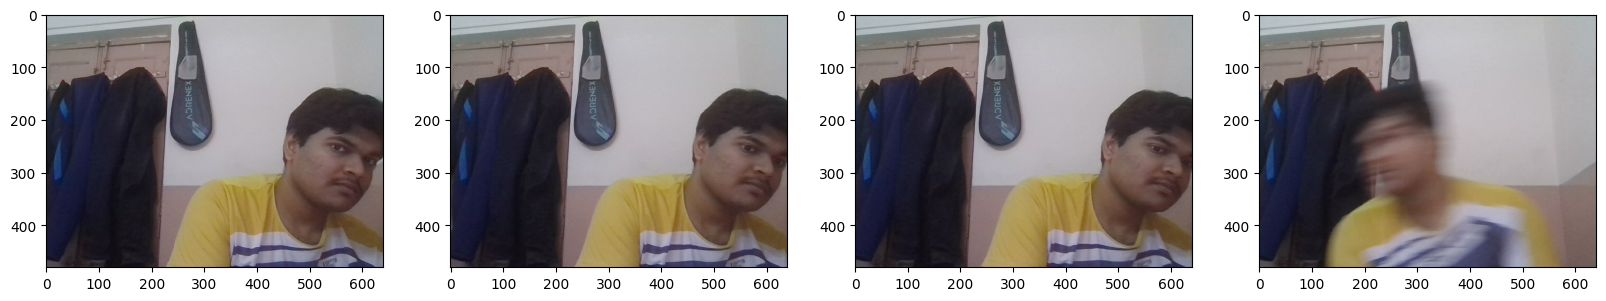

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [36]:
90*.7 # 63 to train

62.99999999999999

In [37]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [38]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [8]:
import albumentations as alb

C:\Users\dghos\anaconda3\envs\notebook\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [10]:
img = cv2.imread(os.path.join('data','train', 'images','54be695f-f59c-11ef-9e3b-80b655fcc154.jpg'))

In [11]:
img.shape

(480, 640, 3)

In [12]:
img

array([[[193, 185, 178],
        [191, 183, 176],
        [190, 182, 175],
        ...,
        [179, 175, 170],
        [179, 175, 170],
        [178, 174, 169]],

       [[193, 185, 178],
        [191, 183, 176],
        [190, 182, 175],
        ...,
        [179, 175, 170],
        [179, 175, 170],
        [178, 174, 169]],

       [[193, 185, 178],
        [191, 183, 176],
        [190, 183, 174],
        ...,
        [179, 175, 170],
        [178, 174, 169],
        [178, 174, 169]],

       ...,

       [[ 88,  78,  90],
        [ 88,  78,  90],
        [ 89,  79,  91],
        ...,
        [150, 130, 129],
        [150, 129, 128],
        [149, 128, 127]],

       [[ 87,  77,  89],
        [ 88,  78,  90],
        [ 88,  78,  90],
        ...,
        [149, 130, 127],
        [148, 127, 126],
        [146, 125, 124]],

       [[ 87,  77,  89],
        [ 87,  77,  89],
        [ 88,  78,  90],
        ...,
        [145, 126, 123],
        [144, 123, 122],
        [142, 121, 120]]

In [13]:
with open(os.path.join('data', 'train', 'labels', '54be695f-f59c-11ef-9e3b-80b655fcc154.json'), 'r') as f:
    label = json.load(f)

In [14]:
label

{'version': '5.6.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[449.4270833333333, 137.91666666666666],
    [639.0, 378.1112341053587]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\54be695f-f59c-11ef-9e3b-80b655fcc154.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8R

In [15]:
type(label)

dict

In [16]:
label['shapes']

[{'label': 'face',
  'points': [[449.4270833333333, 137.91666666666666],
   [639.0, 378.1112341053587]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [17]:
type(label['shapes'])

list

In [18]:
label['shapes'][0]

{'label': 'face',
 'points': [[449.4270833333333, 137.91666666666666],
  [639.0, 378.1112341053587]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {},
 'mask': None}

In [19]:
label['shapes'][0]['points']

[[449.4270833333333, 137.91666666666666], [639.0, 378.1112341053587]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [20]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [21]:
coords  #Converted into a 1D tensor from a 2D tensor
# Pascal-voc = [xmin,ymin,xmax,ymax]

[449.4270833333333, 137.91666666666666, 639.0, 378.1112341053587]

In [22]:
coords = list(np.divide(coords, [640,480,640,480]))  
# Divide by [width,height,width,height]

In [23]:
coords  # Converted from Pascal-voc to albumentations fromat

[0.7022298177083333, 0.2873263888888889, 0.9984375, 0.7877317377194972]

### 4.4 Apply Augmentations and View Results

In [24]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [25]:
augmented

{'image': array([[[170, 139, 126],
         [174, 140, 128],
         [181, 147, 135],
         ...,
         [ 53,  30,  22],
         [ 50,  27,  19],
         [ 47,  24,  16]],
 
        [[172, 143, 130],
         [174, 143, 130],
         [174, 145, 132],
         ...,
         [ 51,  26,  18],
         [ 46,  23,  15],
         [ 45,  22,  14]],
 
        [[171, 144, 131],
         [175, 146, 133],
         [177, 150, 137],
         ...,
         [ 52,  26,  18],
         [ 49,  24,  16],
         [ 49,  24,  16]],
 
        ...,
 
        [[196, 191, 178],
         [196, 191, 178],
         [196, 191, 178],
         ...,
         [198, 190, 168],
         [198, 190, 168],
         [199, 191, 169]],
 
        [[197, 192, 179],
         [197, 192, 179],
         [197, 192, 179],
         ...,
         [199, 191, 169],
         [198, 190, 168],
         [199, 191, 169]],
 
        [[197, 192, 179],
         [197, 192, 179],
         [197, 192, 179],
         ...,
         [198, 190,

In [26]:
type(augmented)

dict

In [27]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [28]:
augmented['image'].shape  #Converted to 450 x 450

(450, 450, 3)

In [29]:
augmented['bboxes']

[[0.0, 0.19975278218587245, 0.041273176405164924, 0.7335185114542645]]

In [30]:
augmented['bboxes'][0][:2] # First 2 coordinates

[0.0, 0.19975278218587245]

In [31]:
augmented['bboxes'][0][2:] # Last 2 coordinates

[0.041273176405164924, 0.7335185114542645]

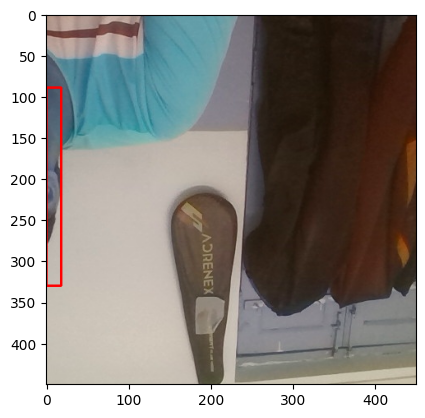

In [32]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), #First 2 coordinates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), # Last 2 coordinates
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [33]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001] # CDefaut coodinates incase there is no annotations available
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):  # 60 images per base image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.25545248 0.97309029 0.         0.51765501 0.        ].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [34]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))  # Compressing to 120 x 120 so that we get more efficient NN
train_images = train_images.map(lambda x: x/255)  #Scaling the images between 0 & 1 so that we use sigmoid activation fucntion int he final layer

In [35]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [36]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [37]:
train_images.as_numpy_iterator().next()

array([[[0.7043505 , 0.74356616, 0.7474877 ],
        [0.7076593 , 0.74626225, 0.7522672 ],
        [0.7165441 , 0.75085783, 0.76115197],
        ...,
        [0.721875  , 0.721875  , 0.7140319 ],
        [0.72922796, 0.72922796, 0.7213848 ],
        [0.71427697, 0.71427697, 0.7113358 ]],

       [[0.50447303, 0.5476103 , 0.5554534 ],
        [0.45900735, 0.50214463, 0.5099878 ],
        [0.4273897 , 0.46709558, 0.47493872],
        ...,
        [0.71721816, 0.71721816, 0.71721816],
        [0.72457105, 0.72457105, 0.72457105],
        [0.7158701 , 0.7158701 , 0.7158701 ]],

       [[0.45392156, 0.4995098 , 0.502451  ],
        [0.4353554 , 0.47849265, 0.48633578],
        [0.43529412, 0.47843137, 0.4862745 ],
        ...,
        [0.71666664, 0.71666664, 0.71666664],
        [0.7132353 , 0.7132353 , 0.7132353 ],
        [0.7163603 , 0.7163603 , 0.7163603 ]],

       ...,

       [[0.23314951, 0.2096201 , 0.24883579],
        [0.20686275, 0.18333334, 0.22254902],
        [0.20539215, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [74]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels.as_numpy_iterator().next()

b'aug_data\\train\\labels\\54be695f-f59c-11ef-9e3b-80b655fcc154.0.json'

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.7964, 0.2465, 1.    , 0.7803], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000) #Shuffle bufer should be bigger than the dataset
train = train.batch(8)
train = train.prefetch(4) # Helps to eliminate bottlenecks when we are loading and training a data

In [45]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [84]:
train.as_numpy_iterator().next()

(array([[[[0.5104167 , 0.5496324 , 0.55061275],
          [0.49375   , 0.5337623 , 0.5256128 ],
          [0.5047181 , 0.54001224, 0.52824754],
          ...,
          [0.7112745 , 0.7465686 , 0.74264705],
          [0.72947305, 0.75392157, 0.7536152 ],
          [0.7215074 , 0.75085783, 0.75300246]],
 
         [[0.49607843, 0.529902  , 0.5176471 ],
          [0.5019608 , 0.5362745 , 0.5156863 ],
          [0.49754903, 0.5205882 , 0.50392157],
          ...,
          [0.7240196 , 0.747549  , 0.747549  ],
          [0.72928923, 0.7519608 , 0.7523897 ],
          [0.7245098 , 0.74509805, 0.7459559 ]],
 
         [[0.50582105, 0.52156866, 0.499326  ],
          [0.5117647 , 0.5245098 , 0.4970588 ],
          [0.4976103 , 0.509375  , 0.47420344],
          ...,
          [0.7293505 , 0.7528799 , 0.7528799 ],
          [0.725     , 0.7406863 , 0.74460787],
          [0.72469366, 0.7452819 , 0.7418505 ]],
 
         ...,
 
         [[0.5949142 , 0.50128675, 0.1704044 ],
          [0.59852

In [85]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.4534 , 0.4517 , 0.6743 , 0.7524 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.1888 , 0.332  , 0.6973 ],
        [0.03714, 0.1783 , 0.3843 , 0.544  ]], dtype=float16))

In [87]:
train.as_numpy_iterator().next()[0].shape 
#8 images, 120 x 120 since we have reduced the pixels and 3 colur channels

(8, 120, 120, 3)

### 7.3 View Images and Annotations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


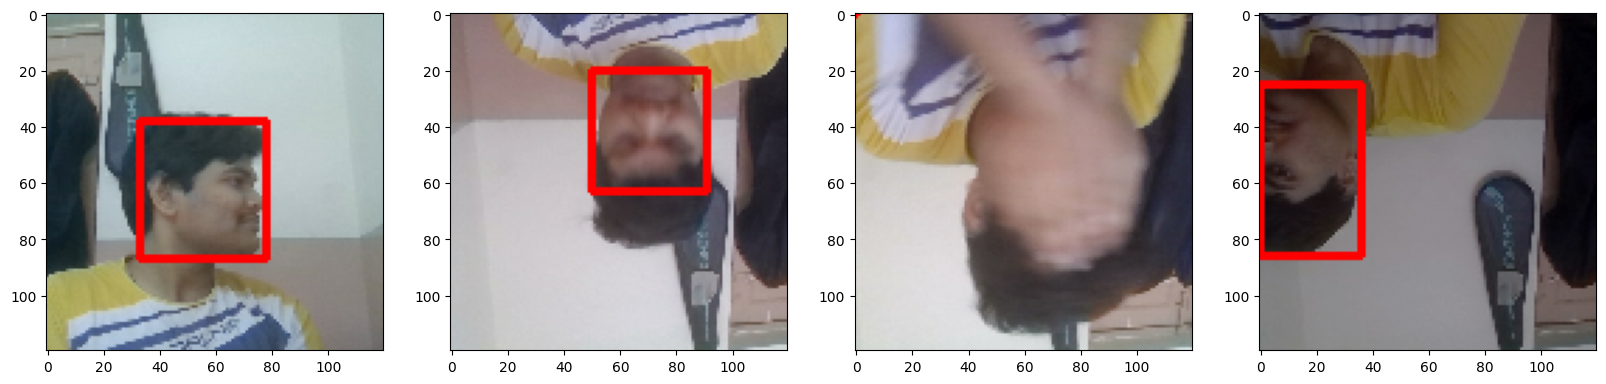

In [47]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = res[0][idx].copy()  # Make writable
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)

    ax[idx].imshow(sample_image)


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [49]:
vgg = VGG16(include_top=False)

In [50]:
vgg.summary()  
# None none none means number of samples, width, height

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [51]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [52]:
facetracker = build_model()

In [53]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
X, y = train.as_numpy_iterator().next()
#X annotations and y is predictions

In [55]:
X

array([[[[0.5930147 , 0.5941789 , 0.6735294 ],
         [0.57058823, 0.5622549 , 0.64460784],
         [0.54068625, 0.52892154, 0.6112745 ],
         ...,
         [0.7331495 , 0.68216914, 0.41550246],
         [0.73590684, 0.6879289 , 0.42941177],
         [0.7254902 , 0.675     , 0.41862744]],

        [[0.5913603 , 0.59528184, 0.6776348 ],
         [0.5697304 , 0.56335783, 0.64865196],
         [0.5280637 , 0.5202206 , 0.6025735 ],
         ...,
         [0.73333335, 0.68235296, 0.41568628],
         [0.7495098 , 0.69503677, 0.43884805],
         [0.7306985 , 0.67579657, 0.42150736]],

        [[0.5998162 , 0.6037378 , 0.6860907 ],
         [0.57598037, 0.57990193, 0.6622549 ],
         [0.5500613 , 0.55398285, 0.6324142 ],
         ...,
         [0.73719364, 0.68621325, 0.41954657],
         [0.7323529 , 0.67745095, 0.422549  ],
         [0.73039216, 0.68284315, 0.43333334]],

        ...,

        [[0.747549  , 0.75147057, 0.7318627 ],
         [0.7500613 , 0.75398284, 0.734375  ]

In [56]:
y

(array([[0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.492 , 0.2379, 0.7407, 0.613 ],
        [0.3596, 0.707 , 1.    , 1.    ],
        [0.1696, 0.278 , 0.557 , 0.6924],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1426, 0.2272, 0.5986, 0.711 ]], dtype=float16))

In [57]:
y[0]

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1]], dtype=uint8)

In [58]:
y[1]

array([[0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.492 , 0.2379, 0.7407, 0.613 ],
       [0.3596, 0.707 , 1.    , 1.    ],
       [0.1696, 0.278 , 0.557 , 0.6924],
       [0.    , 0.    , 0.    , 0.    ],
       [0.1426, 0.2272, 0.5986, 0.711 ]], dtype=float16)

In [59]:
X.shape

(8, 120, 120, 3)

In [60]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [61]:
classes, coords

(array([[0.41542155],
        [0.3337494 ],
        [0.41976038],
        [0.41113943],
        [0.34507635],
        [0.40451384],
        [0.4290521 ],
        [0.41376188]], dtype=float32),
 array([[0.7016205 , 0.45266375, 0.5218245 , 0.39407194],
        [0.70094657, 0.45793694, 0.44357872, 0.44843006],
        [0.64094615, 0.50726664, 0.5663079 , 0.41419375],
        [0.7057151 , 0.37059778, 0.5969839 , 0.4519667 ],
        [0.6461191 , 0.5168706 , 0.4795233 , 0.41907376],
        [0.7290181 , 0.44608593, 0.513348  , 0.50181544],
        [0.69370985, 0.43804643, 0.58871824, 0.3988832 ],
        [0.6487013 , 0.40793428, 0.5562531 , 0.45558783]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [62]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

#Learning rate decreases so that it remains 75% of the previous one

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

C:\Users\dghos\anaconda3\envs\notebook\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [64]:
def localization_loss(y_true, yhat):            
    y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
    yhat = tf.cast(yhat, tf.float32)      # Convert yhat to float32

    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size


In [65]:
classloss = tf.keras.losses.BinaryCrossentropy()  # Since noraml classifcation problem
regressloss = localization_loss # Localization loss since we have to predict the bounding box coordinates

### 9.3 Test out Loss Metrics

In [66]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.681342124938965>

In [67]:
localization_loss(y[1], coords).numpy()

5.681342

In [68]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7235089540481567>

In [69]:
classloss(y[0], classes).numpy()

0.72350895

In [70]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.681342124938965>

In [71]:
regressloss(y[1], coords).numpy()

5.681342

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [72]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, (y_classes, y_coords) = batch  # Unpacking tuple explicitly

        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(tf.ensure_shape(y_classes, [None, 1]), classes)
            batch_localizationloss = self.lloss(tf.ensure_shape(y_coords, [None, 4]), coords)


            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        y_classes, y_coords = y  # Unpacking explicitly

        # Ensure correct shapes
        y_classes = tf.ensure_shape(y_classes, [None, 1])
        y_coords = tf.ensure_shape(y_coords, [None, 4])

        batch_classloss = self.closs(y_classes, classes)
        batch_localizationloss = self.lloss(tf.cast(y_coords, tf.float32), coords)

        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [73]:
model = FaceTracker(facetracker)

In [74]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [177]:
for X_batch, y_batch in train.take(1):  # Take one batch from dataset
    print(f"Shape of X: {X_batch.shape}")  # Should be (batch_size, 120, 120, 3)
    print(f"Type of y: {type(y_batch)}")
    print(f"Shape of y[0] (classes): {y_batch[0].shape}")  # Should be (batch_size, num_classes)
    print(f"Shape of y[1] (coords): {y_batch[1].shape}")  # Should be (batch_size, 4)


Shape of X: (8, 120, 120, 3)
Type of y: <class 'tuple'>
Shape of y[0] (classes): (8, 1)
Shape of y[1] (coords): (8, 4)


In [184]:
for batch in train.take(1):
    X, y = batch
    print("X shape:", X.shape)
    print("y type:", type(y))
    print("y[0] shape (classes):", y[0].shape)
    print("y[1] shape (coords):", y[1].shape)


X shape: (8, 120, 120, 3)
y type: <class 'tuple'>
y[0] shape (classes): (8, 1)
y[1] shape (coords): (8, 4)


In [185]:
for X, y in train.take(1):
    print(type(y))  # Should be <class 'tuple'>
    print(len(y))   # Should be 2


<class 'tuple'>
2


In [75]:
logdir='logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - class_loss: 0.2439 - regress_loss: 0.5681 - total_loss: 0.6900 - val_class_loss: 0.0823 - val_regress_loss: 0.1725 - val_total_loss: 0.2136
Epoch 2/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - class_loss: 0.0676 - regress_loss: 0.1646 - total_loss: 0.1984 - val_class_loss: 1.8484 - val_regress_loss: 1.7020 - val_total_loss: 2.6262
Epoch 3/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - class_loss: 0.0516 - regress_loss: 0.1213 - total_loss: 0.1471 - val_class_loss: 9.8333e-04 - val_regress_loss: 0.1096 - val_total_loss: 0.1101
Epoch 4/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - class_loss: 0.0286 - regress_loss: 0.0720 - total_loss: 0.0864 - val_class_loss: 0.0486 - val_regress_loss: 0.1196 - val_total_loss: 0.1439
Epoch 5/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - class_loss: 0.0141 - regress_loss: 0.0347 - total_loss: 0.0418 - val_class_loss: 0.0030 - val_regress_loss: 0.0756 - val_total_loss: 0.0771
Epoch 6/10
465/465 ━━

### 10.3 Plot Performance

In [78]:
hist.history

{'class_loss': [0.11181604117155075,
  0.009964722208678722,
  0.0009697338100522757,
  0.0029635874088853598,
  0.12509632110595703,
  0.0638156458735466,
  0.0005219842423684895,
  0.0006468546343967319,
  0.00020720962493214756,
  0.000796550593804568],
 'regress_loss': [0.29063504934310913,
  0.05899960920214653,
  0.08325168490409851,
  0.05492190271615982,
  0.24455949664115906,
  0.07541143894195557,
  0.061034709215164185,
  0.029661137610673904,
  0.01917143538594246,
  0.027314770966768265],
 'total_loss': [0.3465430736541748,
  0.06398197263479233,
  0.08373655378818512,
  0.05640369653701782,
  0.3071076571941376,
  0.10731926560401917,
  0.061295703053474426,
  0.02998456545174122,
  0.019275039434432983,
  0.027713045477867126],
 'val_class_loss': [0.08229372650384903,
  1.8483545780181885,
  0.0009833304211497307,
  0.048579055815935135,
  0.0029933915939182043,
  1.9805609099421417e-06,
  0.9808588027954102,
  0.004636692814528942,
  0.028432194143533707,
  0.0012350141

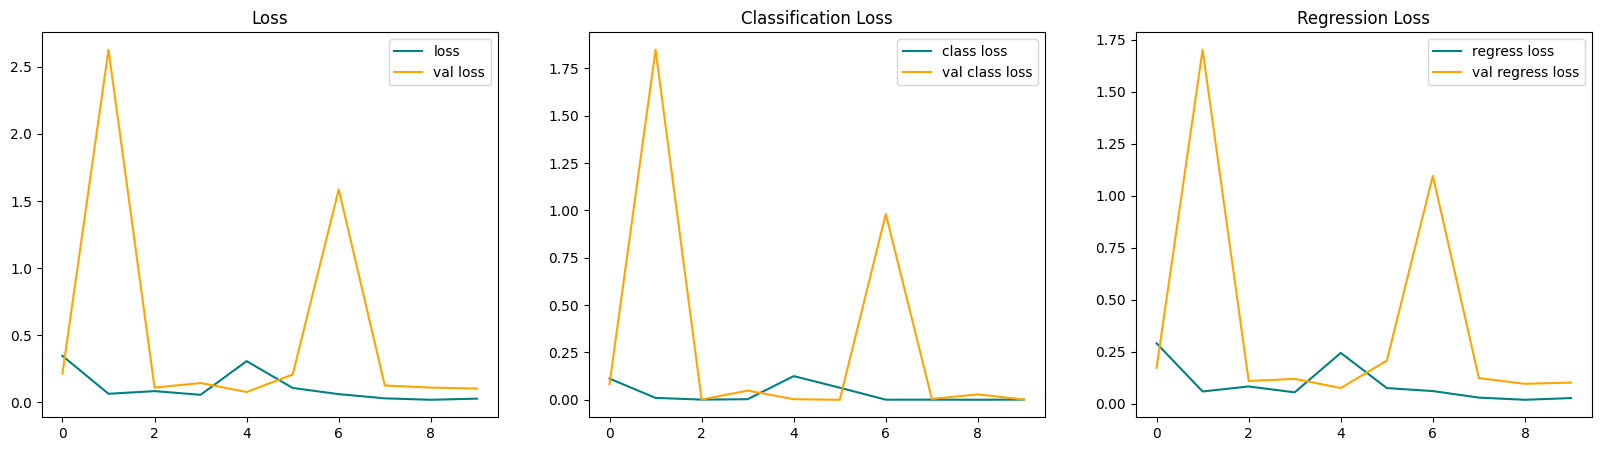

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [80]:
test_data = test.as_numpy_iterator()

In [81]:
test_sample = test_data.next()

In [82]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


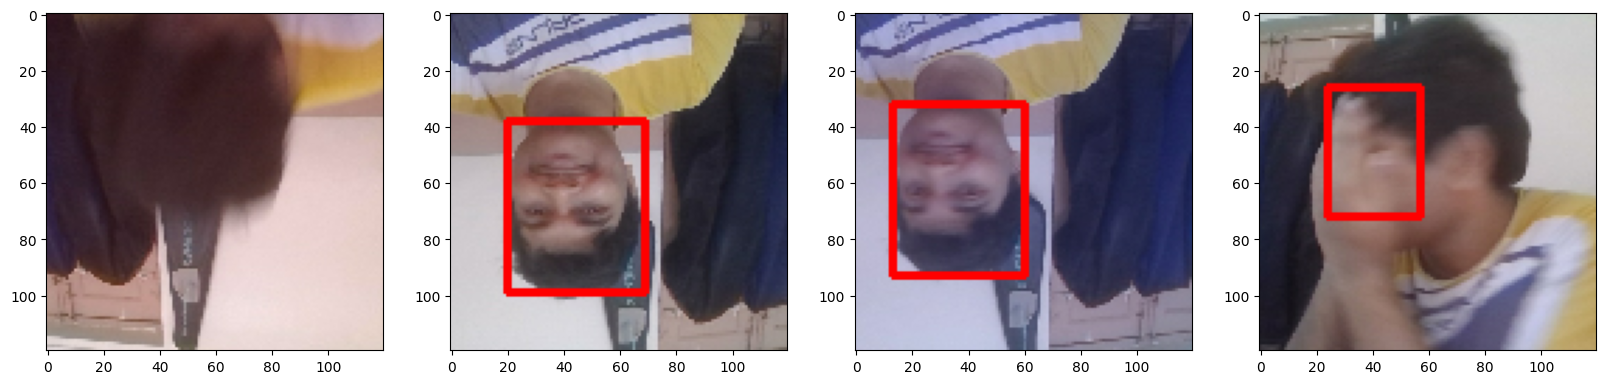

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Ensure image is writable
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                      (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)


### 11.2 Save the Model

In [84]:
from tensorflow.keras.models import load_model

In [233]:
facetracker.save('facetracker.h5')

In [234]:
facetracker = load_model('facetracker.h5')

In [85]:
import keras.saving
keras.saving.save_model(facetracker, 'facetracker.keras')

In [86]:
facetracker = load_model('facetracker.keras')

### 11.3 Real Time Detection

In [87]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 